In [1]:
import numpy as np
np.warnings.simplefilter("ignore")
# MultiLayerNetExtendにwarningがあったので消す
% matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# 確率的勾配降下法
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [3]:
# 慣性の概念を取り入れる
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [4]:
# 学習係数を減衰させる
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [5]:
# momentumとadagradを融合
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

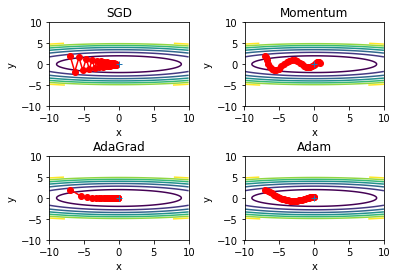

In [6]:
# 2変数の二次関数でプロットしてみる
from collections import OrderedDict


def f(x, y):
    return (x**2 / 20.0) + y**2


def df(x, y):
    return x / 10.0, 2.0*y

# 初期値
init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

# 比較する最適化手法
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        # xとyについてそれぞれ偏微分
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

In [7]:
# それぞれの最適化法を損失関数を観察して検証する
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 検証する最適化手法
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}

for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 訓練する
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    # 損失関数の値を出力
    if i % 500 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
Momentum:2.4079754797167876
Adam:2.3888736288462202
SGD:2.5236239940716265
AdaGrad:2.5519527166191196
===========iteration:500===========
Momentum:0.07953913932515505
Adam:0.09607454489674723
SGD:0.3417168540586806
AdaGrad:0.04812738870311886
===========iteration:1000===========
Momentum:0.13020398260465918
Adam:0.060253999472734736
SGD:0.2739377202253247
AdaGrad:0.06395479344670457
===========iteration:1500===========
Momentum:0.06400183997616744
Adam:0.028499654021575428
SGD:0.18800950705923203
AdaGrad:0.022199205862653247


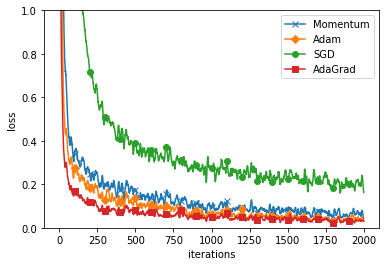

In [8]:
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

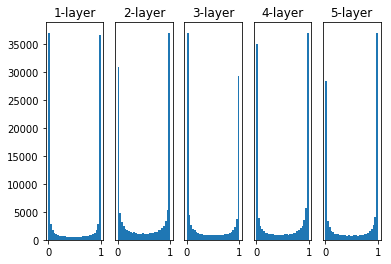

In [9]:
# 入力をニューラルネットに流してsigmoidでアクティベーションした結果について、各層で分布を観察
# 重みの標準偏差を小さくすると値が1と0付近(つまりsigmoidへの入力の絶対値が大きい)ことがわかる
# バックプロパゲートしようとした時に1と0付近のsigmoidの微分の値を何回も掛けてしまうことで勾配が極めて小さくなってしまう
# 重みの分散が大きいと端の学習が全くすすまない勾配消失がおこる
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 入力は正規分布する要素100個からなるサンプル1000個
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    # 重みの標準偏差を1にする
    w = np.random.randn(node_num, node_num) * 1
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    # y軸の目盛りを消す
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

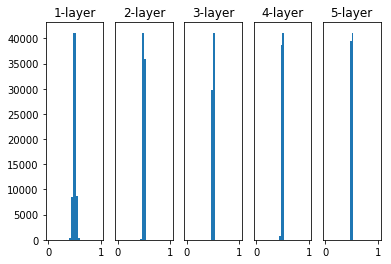

In [10]:
# 重みの標準偏差を小さくすると値が0.5付近(つまりsigmoidへの入力が0付近になる)ことがわかる
# これはこれで、複数の重みがほぼ同じ値になってしまうので、重みを複数持つ意味がなくなってしまう
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    # 重みの標準偏差を0.01にする
    w = np.random.randn(node_num, node_num) * 0.01
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

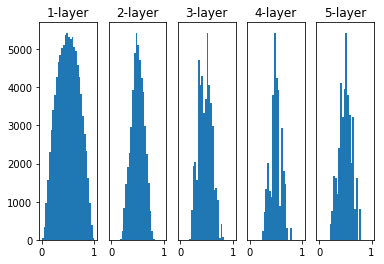

In [11]:
# Xavierの初期値
# ディープラーニングのフレームワークで標準的に使われる手法
# 前層のノードの個数をnとしたとき、sqrt(1/n) の標準偏差を持つガウス分布として重みの初期値を設定する
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

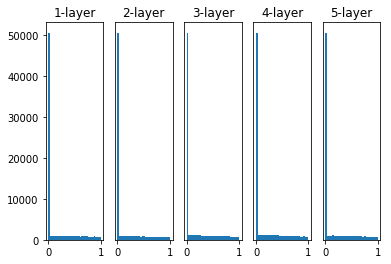

In [12]:
# Heの初期値
# reluで活性させるときに使う
# 前層のノードの個数をnとしたとき、sqrt(2/n) の標準偏差を持つガウス分布として重みの初期値を設定する
def relu(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num/2)
    z = np.dot(x, w)
    a = relu(z)
    activations[i] = a

# Heの初期値を使うとreluを使っても分布が均一になる(単純なガウス分布やXavierの初期値では偏る)
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

In [13]:
# それぞれの重みの初期化方法を比較する
# アクティベーションにはreluを使用
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 検証する最適化手法
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)


networks = {}
train_loss = {}

for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100],
        output_size=10,
        weight_init_std=weight_type
    )
    train_loss[key] = []

# 訓練する
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    # 損失関数の値を出力
    if i % 500 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
Xavier:2.3224157938618077
He:2.3542842565860838
std=0.01:2.302410461986111
===========iteration:500===========
Xavier:0.7231517963169365
He:0.2386896221809484
std=0.01:2.2989614857194725
===========iteration:1000===========
Xavier:0.3223853903353831
He:0.2199664655980288
std=0.01:2.2991929515784837
===========iteration:1500===========
Xavier:0.20698286424608903
He:0.15637458140606691
std=0.01:2.3063330170711005


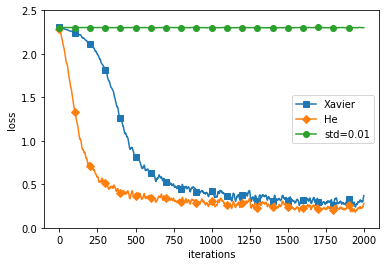

In [14]:
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

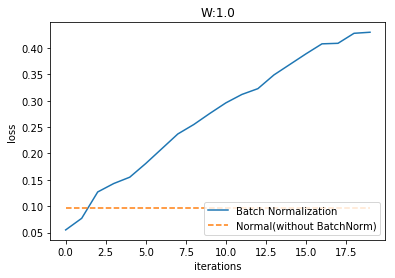

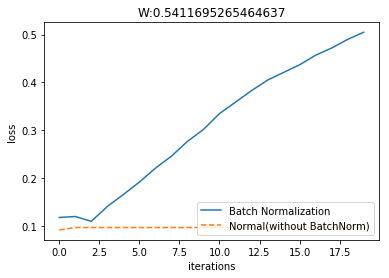

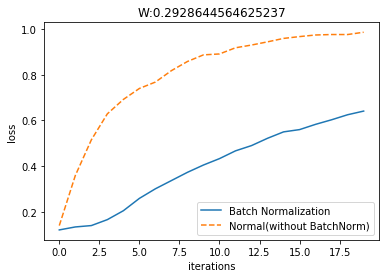

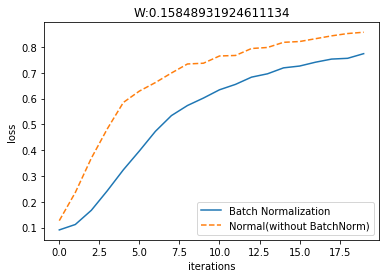

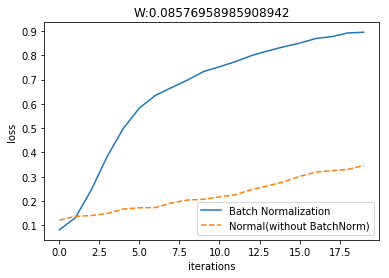

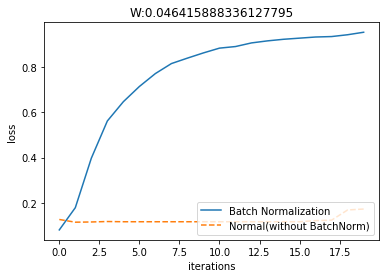

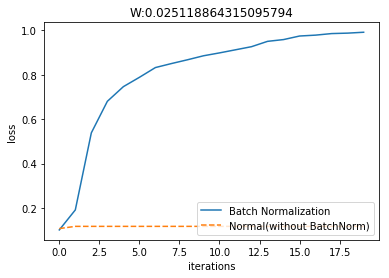

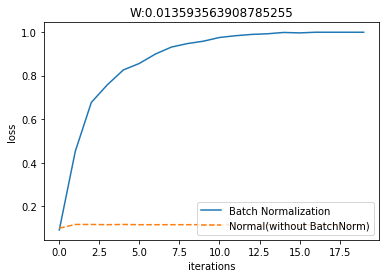

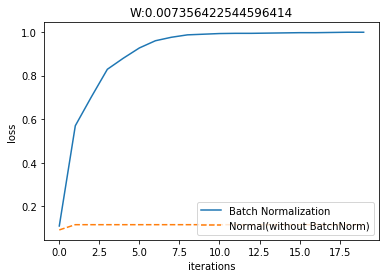

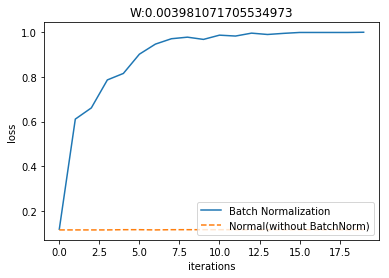

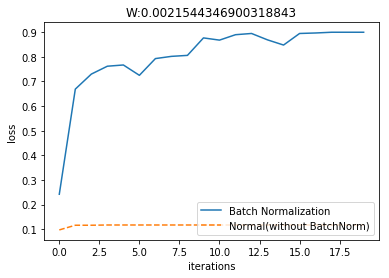

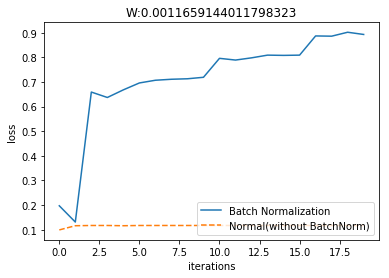

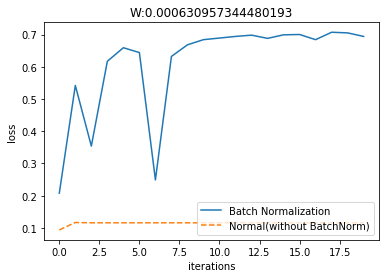

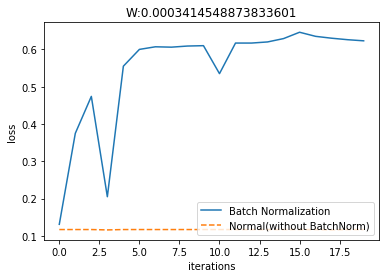

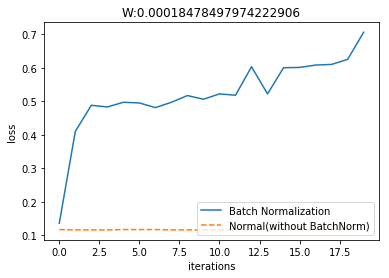

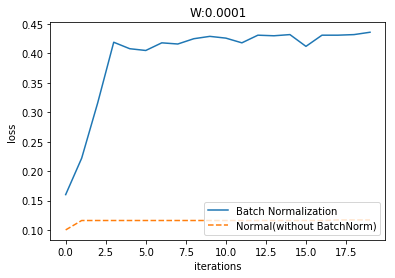

In [15]:
# batch normalization: 入力層からデータを無作為抽出してそこから標準偏差と平均をだして入力の分布をノーマライズする
# どの重みの初期値であってもbatch normalizationの学習速度が良いことを確認する
from common.multi_layer_net_extend import MultiLayerNetExtend

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
　　# batch_normalizationするネットワーク
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    # batch_normalizationしないネットワーク
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
　　　　# 無作為抽出してミニバッチ学習
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# グラフ描画
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    train_acc_list, bn_train_acc_list = __train(w)
    plt.title("W:" + str(w))
    plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
    plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    plt.xlabel("iterations")
    plt.ylabel("loss")
    plt.legend(loc='lower right')
    plt.show()